<a href="https://colab.research.google.com/github/Jsgithubchannel/deep_learning_practice/blob/main/situation_model_more_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. 코랩 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

     |████████████████████████████████| 47.3 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 4.5 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595739 sha256=83e11b41278293e4b889b5c7aa4efe0dd7d56b272e011e50bc4cd45025336bdd
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 4.3 MB/s 
     |████████████████████████████████| 3.4 MB 4.4 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
     |████████████████████████████████| 61 kB 480 kB/s 
     |████████████████████████████████| 596 kB 55.6 MB/s 
     |████████████████████████████████| 3.3 MB 45.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13


In [2]:
#Kobert 파일 로드 from github
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-z8ljlklx
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-z8ljlklx
     |████████████████████████████████| 4.9 MB 3.7 MB/s 
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=13136 sha256=41ba1e178353b1adbdc7c29dba385239dfe73c7285dd86829cbc04347b212ecd
  Stored in directory: /tmp/pip-ephem-wheel-cache-rg3i53lc/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert


In [3]:
# 환경 설정 (필요한 모듈 import)
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [4]:
#GPU 사용 시
device = torch.device("cuda:0")
#device = torch.device("cpu")

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 2. 데이터셋 전처리
import pandas as pd
chat_data = pd.read_excel('/content/drive/MyDrive/capstone_design/situation_dataset.xlsx')

In [7]:
print(len(chat_data)) # 데이터 개수
chat_data.sample(n=10) # 랜덤 데이터 10개 출력

74855


,situation,sentence1,sentence2,sentence3
39208,대인관계,어제 언니가 결혼할 사람이라고 남자친구를 갑자기 데려왔어.,언니가 좋다면 나도 어쩔 수 없지만 아직은 아쉬워.,그래. 예비 형부가 어떤 사람인지 좀 더 물어봐야겠어.
38164,건강,약한 빈혈이 있어서 딸이 철분제를 사줬는데도 안 먹었더니 빈혈이 심해졌어.,매일 영양제 챙겨 먹기가 힘들어.,똑같은 상황이 안 되려면 매일 철분제를 챙겨먹어야겠지.
28185,건강,뱃살 좀 빼려고 밤마다 동네한바퀴씩 걷는데 왜 뱃살은 안빠지고 살만 더 찌는것 같지?,요즘 홈트레이닝이 유행이던데 그걸 좀 따라해볼까봐.,NaN
14716,대인관계,남편이 요즘 몸 관리를 소홀하게 하더니 당뇨에 걸렸어.,내가 인슐린 주사도 꼬박꼬박 놔줘야 해.,맞아. 요즘 남편인지 원수인지 모르겠어.
7690,가족관계,나 정말 한심한 거 같다.,병원에서 이제 더 이상 술을 마시면 위험할 거라고 했는데 무시하고 마셨다가 검사해보...,안되겠지만 지금이라도 술을 끊고 건강하게 살거야.
56289,대인관계,이번에 자식이 결혼했는데 전화든 찾아오든 한 친구가 몇 놈 뿐이야. 내가 헛살았나 ...,코로나 때문에 그랬겠지만 계좌번호로 돈이라도 보내야하는 것 아냐?,돈보다 정성이 없다는 게 문제야. 지금까지 잘못 살았나 자꾸 돌이켜보게 돼.
52479,대인관계,우리나라에 감사해야 해.,노인복지가 너무 좋아져서 감사해.,옛날보다 너무 많이 좋아져서 감사하다니까.
48877,"건강, 죽음",요즘 밤에 잠을 못 자서 기분이 안 좋아.,불면증에 좋다는 음식들을 챙겨 먹어 봐도 잠이 안 오니까 미치겠어.,저녁에 운동을 하는 것도 좋다더라고. 오늘은 운동을 해 봐야겠어.
26551,"진로, 취업, 직장",면접에 최종 합격해서 다음 달부터 출근이야 너무 기뻐,맞아 내가 원하던 회사라 더 흥분돼,NaN
71969,학교폭력/따돌림,학교에서 학교폭력을 당하고 있어. 그래서 너무 스트레스받아.,잘 모르겠어.,NaN


In [10]:
situations = ['가족관계','학업 및 진로','학교폭력/따돌림','대인관계(부부, 자녀)','대인관계','연애, 결혼, 출산', '진로, 취업, 직장', '재정, 은퇴, 노후준비', '건강, 죽음', '건강', '직장, 업무 스트레스', '재정'] # 감정 대분류
for i in range(len(situations)):
  chat_data.loc[(chat_data['situation'] == situations[i]), 'situation'] = i

In [11]:
# chat_data
nullcheck1 = chat_data['sentence1'].isnull()
nullcheck2 = chat_data['sentence2'].isnull()
nullcheck3 = chat_data['sentence3'].isnull()

data_list = []
for check1,check2, check3, label, sentence1, sentence2, sentence3 in zip(nullcheck1,nullcheck2, nullcheck3, chat_data['situation'], chat_data['sentence1'], chat_data['sentence2'], chat_data['sentence3'])  :
    data = []
    sentence = ""

    if check1 != True :
      sentence = sentence1

    if check2 != True :
      sentence = sentence + " " + str(sentence2)

    if check3 != True :
      sentence = sentence + " " + sentence3
    
    
    data.append(sentence)
    data.append(str(label))

    data_list.append(data)

In [13]:
data_list[25300]

['딸이 졸업식에 오는 엄마들 중 내가 젤 옷을 잘 입을거래 뭘 입고가야할지 더 고민돼 딸에게 부끄럽지 않은 엄마라 기뻐', '3']

In [14]:
# 3. Train data & Test data
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [15]:
# 4. KoBERT 입력 데이터로 만들기

# BERT 모델에 들어가기 위한 dataset을 만들어주는 클래스
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [16]:
# Setting parameters
max_len = 200
batch_size = 16
warmup_ratio = 0.1
num_epochs = 100
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [17]:
print(len(dataset_train))
print(len(dataset_test))

59884
14971


In [18]:
#토큰화
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

#BERT 모델, Vocabulary 불러오기
from kobert.pytorch_kobert import get_kobert_model
bertmodel, vocab = get_kobert_model('skt/kobert-base-v1',tokenizer.vocab_file) 

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-115t3rtl/kobert-tokenizer_46ea4cb3f306403b86bbc23563355f08
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-115t3rtl/kobert-tokenizer_46ea4cb3f306403b86bbc23563355f08
  Created wheel for kobert-tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4648 sha256=f9ab15d70c09d4d99c27c6c31fe52567df8f1663268ecaf2ab11a83452ee33b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-pji5lbk7/wheels/10/b4/d9/cb627bbfaefa266657b0b4e8127f7bf96d27376fa1a23897b4
Successfully built kobert-tokenizer


Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/244 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/432 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


Downloading:   0%|          | 0.00/535 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

In [19]:
tok=tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok,vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok,vocab,  max_len, True, False)

In [20]:
data_train[0]

(array([   2, 1406, 3969, 7170, 5719, 3604, 7865, 1425, 7086, 3439, 4501,
        3604, 7864, 6855,   54, 1425, 7096, 3604, 7811, 1394, 4983, 2363,
        5760, 2964,  517, 6158, 7088, 4252, 3166, 6827, 5761, 2962, 6150,
        1370, 6198, 3890, 4628, 7788, 6150, 1815, 6516, 7788, 1504, 6037,
        6150, 1563,   54, 1397, 1804, 1425, 7835, 2302, 6060, 7344, 1549,
        7096, 6844,   54,    3,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1, 

In [21]:
# torch 형식의 dataset
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
# 5. KoBERT 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=12, ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [23]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [26]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/capstone_design/checkpoint_more_datasets.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [27]:
def train_model(model, batch_size, patience, num_epochs):
  # 6. KoBERT 모델 학습시키기

  train_losses = [] # 모델이 학습되는 동안 trainning loss를 track
  valid_losses = [] # 모델이 학습되는 동안 validation loss를 track
  avg_train_losses = [] # epoch당 average training loss를 track
  avg_valid_losses = [] # epoch당 average validation loss를 track

  # early_stopping object의 초기화
  early_stopping = EarlyStopping(patience = patience, verbose = True)

  for epoch in range(1, num_epochs + 1):
      train_acc = 0.0
      test_acc = 0.0
      ###################
      # train the model #
      ###################
      model.train()
      for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
          optimizer.zero_grad()

          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)

          out = model(token_ids, valid_length, segment_ids)

          loss = loss_fn(out, label)
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
          optimizer.step()
          scheduler.step()  # Update learning rate schedule
          train_acc += calc_accuracy(out, label)
          if batch_id % log_interval == 0:
              print("epoch {} batch id {} loss {} train acc {}".format(epoch, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
      train_losses.append(loss.item()) # train loss 기록



      ######################    
      # validate the model #
      ######################
      model.eval()
      for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
          token_ids = token_ids.long().to(device)
          segment_ids = segment_ids.long().to(device)
          valid_length= valid_length
          label = label.long().to(device)

          out = model(token_ids, valid_length, segment_ids)
          test_acc += calc_accuracy(out, label)
          loss = loss_fn(out, label) # loss 계산
          valid_losses.append(loss.item()) # vaildation loss 기록
      print("epoch {} test acc {}".format(epoch+1, test_acc / (batch_id+1)))

      # print 학습/검증 statistics
      # epoch당 평균 loss 계산
      train_loss = np.average(train_losses)
      valid_loss = np.average(valid_losses)
      avg_train_losses.append(train_loss)
      avg_valid_losses.append(valid_loss)

      epoch_len = len(str(num_epochs))
      print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                        f'train_loss: {train_loss:.5f} ' +
                        f'valid_loss: {valid_loss:.5f}')
      print(print_msg)

      # 다음 에폭 track하기 위해 리스트 초기화
      train_losses = []
      valid_losses = []

      # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
      # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
      early_stopping(valid_loss, model)

      if early_stopping.early_stop:
        print("Early stopping")
        break

  # best model이 저장되어있는 last checkpoint를 로드한다.
  model.load_state_dict(torch.load('/content/drive/MyDrive/capstone_design/checkpoint_more_datasets.pt'))

  return  model, avg_train_losses, avg_valid_losses

#모델 학습

In [28]:
# early stopping patience;
# validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
patience = 20

model, train_loss, valid_loss = train_model(model, batch_size, patience, num_epochs)   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.5961098670959473 train acc 0.0625
epoch 1 batch id 201 loss 2.576418399810791 train acc 0.07462686567164178
epoch 1 batch id 401 loss 2.3935656547546387 train acc 0.08213840399002494
epoch 1 batch id 601 loss 2.4815001487731934 train acc 0.09349001663893511
epoch 1 batch id 801 loss 2.509993076324463 train acc 0.11056491885143571
epoch 1 batch id 1001 loss 2.246450424194336 train acc 0.12475024975024974
epoch 1 batch id 1201 loss 2.303567409515381 train acc 0.14071606994171523
epoch 1 batch id 1401 loss 2.0425643920898438 train acc 0.16305317630264096
epoch 1 batch id 1601 loss 1.9664429426193237 train acc 0.19323860087445346
epoch 1 batch id 1801 loss 1.7205801010131836 train acc 0.2245280399777901
epoch 1 batch id 2001 loss 1.8454663753509521 train acc 0.25490379810094954
epoch 1 batch id 2201 loss 1.4535995721817017 train acc 0.28237164925034075
epoch 1 batch id 2401 loss 1.6891365051269531 train acc 0.30768429820907955
epoch 1 batch id 2601 loss 1.58522391

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 2 test acc 0.6834693084693085
[  1/100] train_loss: 0.68080 valid_loss: 0.97894
Validation loss decreased (inf --> 0.978938).  Saving model ...


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.130958914756775 train acc 0.6875
epoch 2 batch id 201 loss 1.0028610229492188 train acc 0.6731965174129353
epoch 2 batch id 401 loss 1.1261084079742432 train acc 0.6734725685785536
epoch 2 batch id 601 loss 0.6688578724861145 train acc 0.6741888519134775
epoch 2 batch id 801 loss 0.5009402632713318 train acc 0.6761860174781523
epoch 2 batch id 1001 loss 0.8512840867042542 train acc 0.679070929070929
epoch 2 batch id 1201 loss 1.1948508024215698 train acc 0.6799542048293089
epoch 2 batch id 1401 loss 0.5281826257705688 train acc 0.6814329050678087
epoch 2 batch id 1601 loss 1.3891338109970093 train acc 0.6821908182386008
epoch 2 batch id 1801 loss 0.9230457544326782 train acc 0.6840644086618545
epoch 2 batch id 2001 loss 1.1231017112731934 train acc 0.6862193903048476
epoch 2 batch id 2201 loss 0.9130682945251465 train acc 0.6883518855065879
epoch 2 batch id 2401 loss 0.9323298335075378 train acc 0.6894002498958767
epoch 2 batch id 2601 loss 1.0809122323989868 

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 3 test acc 0.7238005050505051
[  2/100] train_loss: 0.48483 valid_loss: 0.80121
Validation loss decreased (0.978938 --> 0.801208).  Saving model ...


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9888847470283508 train acc 0.6875
epoch 3 batch id 201 loss 0.6599956154823303 train acc 0.7213930348258707
epoch 3 batch id 401 loss 0.9340264797210693 train acc 0.7175810473815462
epoch 3 batch id 601 loss 0.4031703472137451 train acc 0.7207778702163061
epoch 3 batch id 801 loss 0.25774165987968445 train acc 0.7237047440699126
epoch 3 batch id 1001 loss 0.619293749332428 train acc 0.7246503496503497
epoch 3 batch id 1201 loss 0.9710314273834229 train acc 0.7238759367194005
epoch 3 batch id 1401 loss 0.4848315715789795 train acc 0.7249732334047109
epoch 3 batch id 1601 loss 1.177121639251709 train acc 0.726420986883198
epoch 3 batch id 1801 loss 0.6226675510406494 train acc 0.7267143253747917
epoch 3 batch id 2001 loss 1.0639623403549194 train acc 0.7285732133933034
epoch 3 batch id 2201 loss 0.7099802494049072 train acc 0.7297251249432076
epoch 3 batch id 2401 loss 0.8446081876754761 train acc 0.7313098708871304
epoch 3 batch id 2601 loss 0.8470619320869446 

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 4 test acc 0.7313155594405595
[  3/100] train_loss: 0.50073 valid_loss: 0.78696
Validation loss decreased (0.801208 --> 0.786957).  Saving model ...


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.863667368888855 train acc 0.8125
epoch 4 batch id 201 loss 0.6132622361183167 train acc 0.7667910447761194
epoch 4 batch id 401 loss 0.8658941388130188 train acc 0.7596633416458853
epoch 4 batch id 601 loss 0.317605584859848 train acc 0.7588394342762064
epoch 4 batch id 801 loss 0.17309117317199707 train acc 0.7604556803995006
epoch 4 batch id 1001 loss 0.6774619221687317 train acc 0.7617382617382618
epoch 4 batch id 1201 loss 0.9052978157997131 train acc 0.7612926727726894
epoch 4 batch id 1401 loss 0.3469769358634949 train acc 0.7626695217701641
epoch 4 batch id 1601 loss 0.8655136823654175 train acc 0.763897564022486
epoch 4 batch id 1801 loss 0.647110104560852 train acc 0.7649569683509162
epoch 4 batch id 2001 loss 1.1996991634368896 train acc 0.765992003998001
epoch 4 batch id 2201 loss 0.7991794943809509 train acc 0.7668673330304407
epoch 4 batch id 2401 loss 0.8630040884017944 train acc 0.7678571428571429
epoch 4 batch id 2601 loss 0.751210629940033 tra

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 5 test acc 0.7300468628593628
[  4/100] train_loss: 0.55248 valid_loss: 0.83770
EarlyStopping counter: 1 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.6926357746124268 train acc 0.875
epoch 5 batch id 201 loss 0.5363548398017883 train acc 0.7876243781094527
epoch 5 batch id 401 loss 0.597588837146759 train acc 0.7853802992518704
epoch 5 batch id 601 loss 0.19412659108638763 train acc 0.788477537437604
epoch 5 batch id 801 loss 0.1868661344051361 train acc 0.7900280898876404
epoch 5 batch id 1001 loss 0.59543776512146 train acc 0.7903971028971029
epoch 5 batch id 1201 loss 1.0297939777374268 train acc 0.7898626144879267
epoch 5 batch id 1401 loss 0.3923410475254059 train acc 0.7917112776588151
epoch 5 batch id 1601 loss 0.7462217807769775 train acc 0.7918098063710182
epoch 5 batch id 1801 loss 0.2731260657310486 train acc 0.7941768461965575
epoch 5 batch id 2001 loss 1.0873327255249023 train acc 0.7954460269865068
epoch 5 batch id 2201 loss 0.5445119142532349 train acc 0.7967969104952295
epoch 5 batch id 2401 loss 0.8158783316612244 train acc 0.7987036651395252
epoch 5 batch id 2601 loss 0.4685180187225342 tr

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 6 test acc 0.7196605477855478
[  5/100] train_loss: 0.26943 valid_loss: 0.91764
EarlyStopping counter: 2 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.6269252300262451 train acc 0.875
epoch 6 batch id 201 loss 0.4195915460586548 train acc 0.8230721393034826
epoch 6 batch id 401 loss 0.595252275466919 train acc 0.8196695760598504
epoch 6 batch id 601 loss 0.20082935690879822 train acc 0.819883527454243
epoch 6 batch id 801 loss 0.06595250219106674 train acc 0.8221754057428214
epoch 6 batch id 1001 loss 0.5407243967056274 train acc 0.8219280719280719
epoch 6 batch id 1201 loss 0.8315834403038025 train acc 0.8205141548709409
epoch 6 batch id 1401 loss 0.2662883400917053 train acc 0.8207976445396146
epoch 6 batch id 1601 loss 0.5536954998970032 train acc 0.8229622111180512
epoch 6 batch id 1801 loss 0.36777859926223755 train acc 0.8243337034980567
epoch 6 batch id 2001 loss 1.0432811975479126 train acc 0.826180659670165
epoch 6 batch id 2201 loss 0.44949662685394287 train acc 0.826811676510677
epoch 6 batch id 2401 loss 0.5885486006736755 train acc 0.8281445231153686
epoch 6 batch id 2601 loss 0.7482190728187561

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 7 test acc 0.7180883352758354
[  6/100] train_loss: 0.10202 valid_loss: 0.97900
EarlyStopping counter: 3 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.5924034714698792 train acc 0.8125
epoch 7 batch id 201 loss 0.2504113018512726 train acc 0.8473258706467661
epoch 7 batch id 401 loss 0.5283517241477966 train acc 0.8416458852867831
epoch 7 batch id 601 loss 0.12919867038726807 train acc 0.8417221297836939
epoch 7 batch id 801 loss 0.13516120612621307 train acc 0.842852684144819
epoch 7 batch id 1001 loss 0.42108163237571716 train acc 0.8445304695304695
epoch 7 batch id 1201 loss 0.9984917044639587 train acc 0.8450770191507078
epoch 7 batch id 1401 loss 0.2056712508201599 train acc 0.8462259100642399
epoch 7 batch id 1601 loss 0.6074195504188538 train acc 0.8479856339787633
epoch 7 batch id 1801 loss 0.23736004531383514 train acc 0.8483481399222654
epoch 7 batch id 2001 loss 1.01319420337677 train acc 0.8490129935032483
epoch 7 batch id 2201 loss 0.5232772827148438 train acc 0.8499261699227624
epoch 7 batch id 2401 loss 0.6760455369949341 train acc 0.8508694294044148
epoch 7 batch id 2601 loss 0.95165002346038

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 8 test acc 0.7242982711732713
[  7/100] train_loss: 0.08590 valid_loss: 1.03013
EarlyStopping counter: 4 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.6945239305496216 train acc 0.8125
epoch 8 batch id 201 loss 0.48956799507141113 train acc 0.8566542288557214
epoch 8 batch id 401 loss 0.6419451236724854 train acc 0.8573877805486284
epoch 8 batch id 601 loss 0.07663334906101227 train acc 0.8562811980033278
epoch 8 batch id 801 loss 0.03347983956336975 train acc 0.8591604244694132
epoch 8 batch id 1001 loss 0.5028325319290161 train acc 0.8582667332667333
epoch 8 batch id 1201 loss 0.5102251172065735 train acc 0.858191090757702
epoch 8 batch id 1401 loss 0.22099792957305908 train acc 0.8600107066381156
epoch 8 batch id 1601 loss 0.4369904696941376 train acc 0.8613757026858213
epoch 8 batch id 1801 loss 0.3734351098537445 train acc 0.8623681288173237
epoch 8 batch id 2001 loss 0.9878212809562683 train acc 0.8629747626186907
epoch 8 batch id 2201 loss 0.40433254837989807 train acc 0.8625624716038165
epoch 8 batch id 2401 loss 1.0820016860961914 train acc 0.8629997917534361
epoch 8 batch id 2601 loss 1.00880372524

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 9 test acc 0.7019959207459208
[  8/100] train_loss: 0.27222 valid_loss: 1.14953
EarlyStopping counter: 5 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.4449642598628998 train acc 0.9375
epoch 9 batch id 201 loss 0.15606415271759033 train acc 0.8796641791044776
epoch 9 batch id 401 loss 0.4943007826805115 train acc 0.8703241895261845
epoch 9 batch id 601 loss 0.10288922488689423 train acc 0.8729201331114809
epoch 9 batch id 801 loss 0.025783339515328407 train acc 0.8739076154806492
epoch 9 batch id 1001 loss 0.38172298669815063 train acc 0.8743756243756243
epoch 9 batch id 1201 loss 0.8520492911338806 train acc 0.8742194004995837
epoch 9 batch id 1401 loss 0.16379669308662415 train acc 0.875
epoch 9 batch id 1601 loss 0.8594411611557007 train acc 0.875
epoch 9 batch id 1801 loss 0.5025686621665955 train acc 0.8756246529705719
epoch 9 batch id 2001 loss 1.0908814668655396 train acc 0.8752186406796602
epoch 9 batch id 2201 loss 0.6275609135627747 train acc 0.8757099045888233
epoch 9 batch id 2401 loss 0.5825046300888062 train acc 0.8752342773844232
epoch 9 batch id 2601 loss 0.714690625667572 train acc 0.8744713

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 10 test acc 0.7169835372960373
[  9/100] train_loss: 0.02951 valid_loss: 1.19142
EarlyStopping counter: 6 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.2717207074165344 train acc 0.9375
epoch 10 batch id 201 loss 0.5747102499008179 train acc 0.8818407960199005
epoch 10 batch id 401 loss 0.28097912669181824 train acc 0.8824812967581047
epoch 10 batch id 601 loss 0.04360174387693405 train acc 0.8815515806988353
epoch 10 batch id 801 loss 0.1568145900964737 train acc 0.880539950062422
epoch 10 batch id 1001 loss 0.5568816661834717 train acc 0.8807442557442557
epoch 10 batch id 1201 loss 0.5269449949264526 train acc 0.8794754371357202
epoch 10 batch id 1401 loss 0.05608357489109039 train acc 0.8803533190578159
epoch 10 batch id 1601 loss 0.745999813079834 train acc 0.881128981886321
epoch 10 batch id 1801 loss 0.13581162691116333 train acc 0.8809342032204331
epoch 10 batch id 2001 loss 0.8740559816360474 train acc 0.8808095952023988
epoch 10 batch id 2201 loss 0.6371131539344788 train acc 0.881133575647433
epoch 10 batch id 2401 loss 0.807212769985199 train acc 0.8797636401499376
epoch 10 batch id 2601 loss 0.47

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 11 test acc 0.706840034965035
[ 10/100] train_loss: 0.33433 valid_loss: 1.28781
EarlyStopping counter: 7 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.5913657546043396 train acc 0.875
epoch 11 batch id 201 loss 0.0680825486779213 train acc 0.888681592039801
epoch 11 batch id 401 loss 0.4948451519012451 train acc 0.8810785536159601
epoch 11 batch id 601 loss 0.12708990275859833 train acc 0.882279534109817
epoch 11 batch id 801 loss 0.019411370158195496 train acc 0.883270911360799
epoch 11 batch id 1001 loss 0.3458886742591858 train acc 0.8847402597402597
epoch 11 batch id 1201 loss 0.6087636947631836 train acc 0.8833263946711074
epoch 11 batch id 1401 loss 0.11636501550674438 train acc 0.8849036402569593
epoch 11 batch id 1601 loss 0.7171095013618469 train acc 0.8850327920049968
epoch 11 batch id 1801 loss 0.20321398973464966 train acc 0.8849944475291505
epoch 11 batch id 2001 loss 1.0263108015060425 train acc 0.8842141429285357
epoch 11 batch id 2201 loss 0.6573423147201538 train acc 0.8846547024079964
epoch 11 batch id 2401 loss 0.43380022048950195 train acc 0.8848136193252811
epoch 11 batch id 2601 loss 0

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 12 test acc 0.7208928224553225
[ 11/100] train_loss: 0.06025 valid_loss: 1.20855
EarlyStopping counter: 8 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 0.3667845129966736 train acc 0.9375
epoch 12 batch id 201 loss 0.4985738694667816 train acc 0.8964552238805971
epoch 12 batch id 401 loss 0.6826029419898987 train acc 0.8933915211970075
epoch 12 batch id 601 loss 0.31607550382614136 train acc 0.8938227953410982
epoch 12 batch id 801 loss 0.027377832680940628 train acc 0.8945848938826467
epoch 12 batch id 1001 loss 0.3404993414878845 train acc 0.8951673326673326
epoch 12 batch id 1201 loss 0.48075154423713684 train acc 0.8963884263114071
epoch 12 batch id 1401 loss 0.19523005187511444 train acc 0.8978854389721628
epoch 12 batch id 1601 loss 0.625784158706665 train acc 0.8988132417239225
epoch 12 batch id 1801 loss 0.15818536281585693 train acc 0.8993614658523043
epoch 12 batch id 2001 loss 0.9918349385261536 train acc 0.8983633183408296
epoch 12 batch id 2201 loss 0.446258008480072 train acc 0.8991935483870968
epoch 12 batch id 2401 loss 0.39901503920555115 train acc 0.8991045397750937
epoch 12 batch id 2601 los

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 13 test acc 0.7098387723387724
[ 12/100] train_loss: 0.02917 valid_loss: 1.32586
EarlyStopping counter: 9 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 0.3439437448978424 train acc 0.875
epoch 13 batch id 201 loss 0.01446019671857357 train acc 0.9107587064676617
epoch 13 batch id 401 loss 0.4090811312198639 train acc 0.9096009975062345
epoch 13 batch id 601 loss 0.015682697296142578 train acc 0.9095257903494176
epoch 13 batch id 801 loss 0.006459047552198172 train acc 0.9098782771535581
epoch 13 batch id 1001 loss 0.30150485038757324 train acc 0.9096528471528471
epoch 13 batch id 1201 loss 0.14141599833965302 train acc 0.9096065778517902
epoch 13 batch id 1401 loss 0.016999555751681328 train acc 0.9103765167737331
epoch 13 batch id 1601 loss 0.7633105516433716 train acc 0.9113835103060587
epoch 13 batch id 1801 loss 0.2619834542274475 train acc 0.9111257634647418
epoch 13 batch id 2001 loss 0.8827154040336609 train acc 0.9114192903548226
epoch 13 batch id 2201 loss 0.4812859892845154 train acc 0.9110347569286688
epoch 13 batch id 2401 loss 0.7464413642883301 train acc 0.9104539775093711
epoch 13 batch id 2601 

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 14 test acc 0.7226592851592851
[ 13/100] train_loss: 0.02279 valid_loss: 1.33446
EarlyStopping counter: 10 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 0.3293273448944092 train acc 0.9375
epoch 14 batch id 201 loss 0.48636338114738464 train acc 0.9098258706467661
epoch 14 batch id 401 loss 0.678512454032898 train acc 0.9047693266832918
epoch 14 batch id 601 loss 0.5218316912651062 train acc 0.9082778702163061
epoch 14 batch id 801 loss 0.005796938203275204 train acc 0.9112047440699126
epoch 14 batch id 1001 loss 0.3615075349807739 train acc 0.9116508491508492
epoch 14 batch id 1201 loss 0.2110172063112259 train acc 0.9111157368859284
epoch 14 batch id 1401 loss 0.022608598694205284 train acc 0.913633119200571
epoch 14 batch id 1601 loss 0.6250331997871399 train acc 0.9141552154903185
epoch 14 batch id 1801 loss 0.03491123765707016 train acc 0.9151860077734592
epoch 14 batch id 2001 loss 0.6357923746109009 train acc 0.9145114942528736
epoch 14 batch id 2201 loss 0.40373286604881287 train acc 0.9146978646069969
epoch 14 batch id 2401 loss 0.5383603572845459 train acc 0.9147750937109538
epoch 14 batch id 2601 los

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 15 test acc 0.7108464452214452
[ 14/100] train_loss: 0.10215 valid_loss: 1.45694
EarlyStopping counter: 11 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 0.24295400083065033 train acc 0.9375
epoch 15 batch id 201 loss 0.2545807659626007 train acc 0.9235074626865671
epoch 15 batch id 401 loss 1.0887951850891113 train acc 0.9175498753117207
epoch 15 batch id 601 loss 0.07178126275539398 train acc 0.9195091514143094
epoch 15 batch id 801 loss 0.010226883925497532 train acc 0.9214263420724095
epoch 15 batch id 1001 loss 0.25230488181114197 train acc 0.9210789210789211
epoch 15 batch id 1201 loss 0.11604049801826477 train acc 0.9218880099916736
epoch 15 batch id 1401 loss 0.1495250165462494 train acc 0.9226891506067095
epoch 15 batch id 1601 loss 0.7792686820030212 train acc 0.9245393504059962
epoch 15 batch id 1801 loss 0.18283145129680634 train acc 0.9251457523598001
epoch 15 batch id 2001 loss 0.4586443305015564 train acc 0.9248500749625187
epoch 15 batch id 2201 loss 0.06530110538005829 train acc 0.9246649250340754
epoch 15 batch id 2401 loss 0.9156003594398499 train acc 0.9249531445231154
epoch 15 batch id 2601 

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 16 test acc 0.7166193181818182
[ 15/100] train_loss: 0.00853 valid_loss: 1.49213
EarlyStopping counter: 12 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.05814678966999054 train acc 0.9375
epoch 16 batch id 201 loss 0.07661750167608261 train acc 0.9281716417910447
epoch 16 batch id 401 loss 0.40815696120262146 train acc 0.9247194513715711
epoch 16 batch id 601 loss 0.010978234931826591 train acc 0.9266846921797005
epoch 16 batch id 801 loss 0.005182660650461912 train acc 0.9257178526841449
epoch 16 batch id 1001 loss 0.2821894884109497 train acc 0.9276348651348651
epoch 16 batch id 1201 loss 0.5078827142715454 train acc 0.9278205661948377
epoch 16 batch id 1401 loss 0.01298841368407011 train acc 0.9293361884368309
epoch 16 batch id 1601 loss 0.39366552233695984 train acc 0.9299266083697689
epoch 16 batch id 1801 loss 0.5759320855140686 train acc 0.9296918378678511
epoch 16 batch id 2001 loss 0.40809619426727295 train acc 0.9298475762118941
epoch 16 batch id 2201 loss 0.10486793518066406 train acc 0.9300034075420264
epoch 16 batch id 2401 loss 0.6028567552566528 train acc 0.9299250312369846
epoch 16 batch id 26

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 17 test acc 0.7202918609168609
[ 16/100] train_loss: 0.04542 valid_loss: 1.51549
EarlyStopping counter: 13 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.004062453750520945 train acc 1.0
epoch 17 batch id 201 loss 0.019336586818099022 train acc 0.931592039800995
epoch 17 batch id 401 loss 0.3929659426212311 train acc 0.9283042394014963
epoch 17 batch id 601 loss 0.02537495642900467 train acc 0.9297004991680532
epoch 17 batch id 801 loss 0.01339402049779892 train acc 0.9321161048689138
epoch 17 batch id 1001 loss 0.019695430994033813 train acc 0.9325674325674326
epoch 17 batch id 1201 loss 0.045130643993616104 train acc 0.9324521232306411
epoch 17 batch id 1401 loss 0.005829108878970146 train acc 0.9334403997144897
epoch 17 batch id 1601 loss 0.23409131169319153 train acc 0.9340646470955652
epoch 17 batch id 1801 loss 0.08278854191303253 train acc 0.93441143808995
epoch 17 batch id 2001 loss 0.4257214665412903 train acc 0.9341579210394803
epoch 17 batch id 2201 loss 0.33917489647865295 train acc 0.9341492503407542
epoch 17 batch id 2401 loss 0.14278143644332886 train acc 0.9347667638483965
epoch 17 batch id 260

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 18 test acc 0.7097719988344988
[ 17/100] train_loss: 0.00667 valid_loss: 1.66249
EarlyStopping counter: 14 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.1489899605512619 train acc 0.9375
epoch 18 batch id 201 loss 0.030782297253608704 train acc 0.9443407960199005
epoch 18 batch id 401 loss 1.1535663604736328 train acc 0.9429551122194514
epoch 18 batch id 601 loss 0.11016888171434402 train acc 0.9421797004991681
epoch 18 batch id 801 loss 0.0024377352092415094 train acc 0.9435081148564295
epoch 18 batch id 1001 loss 0.03835432231426239 train acc 0.9423701298701299
epoch 18 batch id 1201 loss 0.6731025576591492 train acc 0.9420795170691091
epoch 18 batch id 1401 loss 0.004921027924865484 train acc 0.943254817987152
epoch 18 batch id 1601 loss 0.3485146164894104 train acc 0.9429653341661461
epoch 18 batch id 1801 loss 0.14816346764564514 train acc 0.9426013325930039
epoch 18 batch id 2001 loss 0.41025522351264954 train acc 0.9427473763118441
epoch 18 batch id 2201 loss 0.5021381378173828 train acc 0.9421285779191276
epoch 18 batch id 2401 loss 0.521163284778595 train acc 0.9425499791753436
epoch 18 batch id 2601

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 19 test acc 0.7121454933954935
[ 18/100] train_loss: 0.95916 valid_loss: 1.65792
EarlyStopping counter: 15 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.013229967094957829 train acc 1.0
epoch 19 batch id 201 loss 0.004951614420861006 train acc 0.9449626865671642
epoch 19 batch id 401 loss 0.4242774546146393 train acc 0.9424875311720698
epoch 19 batch id 601 loss 0.018329884856939316 train acc 0.9434276206322796
epoch 19 batch id 801 loss 0.03398573398590088 train acc 0.9435861423220974
epoch 19 batch id 1001 loss 0.1738537847995758 train acc 0.9453671328671329
epoch 19 batch id 1201 loss 0.43208155035972595 train acc 0.9449937552039966
epoch 19 batch id 1401 loss 0.03926112502813339 train acc 0.945173090649536
epoch 19 batch id 1601 loss 0.13989530503749847 train acc 0.9446830106183636
epoch 19 batch id 1801 loss 0.011076723225414753 train acc 0.944752915047196
epoch 19 batch id 2001 loss 0.24441294372081757 train acc 0.9445902048975512
epoch 19 batch id 2201 loss 0.20672625303268433 train acc 0.9449114039073149
epoch 19 batch id 2401 loss 0.19425728917121887 train acc 0.9454133694294045
epoch 19 batch id 260

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 20 test acc 0.7235637626262627
[ 19/100] train_loss: 0.01978 valid_loss: 1.56007
EarlyStopping counter: 16 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.04742380976676941 train acc 1.0
epoch 20 batch id 201 loss 0.3351897597312927 train acc 0.9477611940298507
epoch 20 batch id 401 loss 0.5787263512611389 train acc 0.9456047381546134
epoch 20 batch id 601 loss 0.37517091631889343 train acc 0.9457154742096506
epoch 20 batch id 801 loss 0.0034279879182577133 train acc 0.9470973782771536
epoch 20 batch id 1001 loss 0.7488882541656494 train acc 0.9470529470529471
epoch 20 batch id 1201 loss 0.32918086647987366 train acc 0.9470753538717736
epoch 20 batch id 1401 loss 0.5173378586769104 train acc 0.9472251962883654
epoch 20 batch id 1601 loss 0.3197951316833496 train acc 0.9477670206121174
epoch 20 batch id 1801 loss 0.0333644263446331 train acc 0.9483967240421988
epoch 20 batch id 2001 loss 0.4030008912086487 train acc 0.9483695652173914
epoch 20 batch id 2201 loss 0.5101712346076965 train acc 0.9484325306678782
epoch 20 batch id 2401 loss 0.23171356320381165 train acc 0.9484069137859226
epoch 20 batch id 2601 loss

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 21 test acc 0.7220279720279721
[ 20/100] train_loss: 0.00607 valid_loss: 1.64887
EarlyStopping counter: 17 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 21 batch id 1 loss 0.07900987565517426 train acc 1.0
epoch 21 batch id 201 loss 0.004812272265553474 train acc 0.9527363184079602
epoch 21 batch id 401 loss 0.8055312633514404 train acc 0.9501246882793017
epoch 21 batch id 601 loss 0.24382872879505157 train acc 0.9486272878535774
epoch 21 batch id 801 loss 0.002126967767253518 train acc 0.9504525593008739
epoch 21 batch id 1001 loss 0.007627353072166443 train acc 0.950487012987013
epoch 21 batch id 1201 loss 0.5492051839828491 train acc 0.9503018318068276
epoch 21 batch id 1401 loss 0.005604407750070095 train acc 0.949768022840828
epoch 21 batch id 1601 loss 0.47185981273651123 train acc 0.9507339163023111
epoch 21 batch id 1801 loss 0.0028531712014228106 train acc 0.9514158800666297
epoch 21 batch id 2001 loss 0.012303481809794903 train acc 0.951555472263868
epoch 21 batch id 2201 loss 0.010697463527321815 train acc 0.9516412994093594
epoch 21 batch id 2401 loss 0.1811748594045639 train acc 0.9518950437317785
epoch 21 batch id 2

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 22 test acc 0.7238308566433567
[ 21/100] train_loss: 0.00416 valid_loss: 1.74592
EarlyStopping counter: 18 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 22 batch id 1 loss 0.0018867612816393375 train acc 1.0
epoch 22 batch id 201 loss 0.00202048197388649 train acc 0.9605099502487562
epoch 22 batch id 401 loss 0.7701357007026672 train acc 0.9538653366583542
epoch 22 batch id 601 loss 0.12238545715808868 train acc 0.9533069883527454
epoch 22 batch id 801 loss 0.0015267638955265284 train acc 0.9538857677902621
epoch 22 batch id 1001 loss 0.0017978049581870437 train acc 0.954483016983017
epoch 22 batch id 1201 loss 0.14941471815109253 train acc 0.9541527893422148
epoch 22 batch id 1401 loss 0.004157726187258959 train acc 0.9545860099928622
epoch 22 batch id 1601 loss 0.7200339436531067 train acc 0.9544815740162399
epoch 22 batch id 1801 loss 0.1225014328956604 train acc 0.9550249861188229
epoch 22 batch id 2001 loss 0.5277104377746582 train acc 0.9550537231384307
epoch 22 batch id 2201 loss 0.30428847670555115 train acc 0.9547932757837346
epoch 22 batch id 2401 loss 0.40060955286026 train acc 0.9550447730112454
epoch 22 batch id 2601

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 23 test acc 0.7191567113442114
[ 22/100] train_loss: 0.11107 valid_loss: 1.69178
EarlyStopping counter: 19 out of 20


  0%|          | 0/3743 [00:00<?, ?it/s]

epoch 23 batch id 1 loss 0.3086509108543396 train acc 0.9375
epoch 23 batch id 201 loss 0.0015362945850938559 train acc 0.9542910447761194
epoch 23 batch id 401 loss 0.6954888105392456 train acc 0.953709476309227
epoch 23 batch id 601 loss 0.0024660725612193346 train acc 0.9540349417637272
epoch 23 batch id 801 loss 0.012142866849899292 train acc 0.9553682896379525
epoch 23 batch id 1001 loss 0.6730126738548279 train acc 0.9560439560439561
epoch 23 batch id 1201 loss 0.605057954788208 train acc 0.9564425478767694
epoch 23 batch id 1401 loss 0.028211791068315506 train acc 0.9573072805139187
epoch 23 batch id 1601 loss 0.41508421301841736 train acc 0.9574484697064335
epoch 23 batch id 1801 loss 0.21115072071552277 train acc 0.958252359800111
epoch 23 batch id 2001 loss 0.3546014130115509 train acc 0.9581459270364817
epoch 23 batch id 2201 loss 0.5021845102310181 train acc 0.9577180826896865
epoch 23 batch id 2401 loss 0.004180643707513809 train acc 0.9574916701374427
epoch 23 batch id 26

  0%|          | 0/936 [00:00<?, ?it/s]

epoch 24 test acc 0.728772095959596
[ 23/100] train_loss: 0.00312 valid_loss: 1.81454
EarlyStopping counter: 20 out of 20
Early stopping


##[참고]loss랑 early stopping 체크포인트 가시화

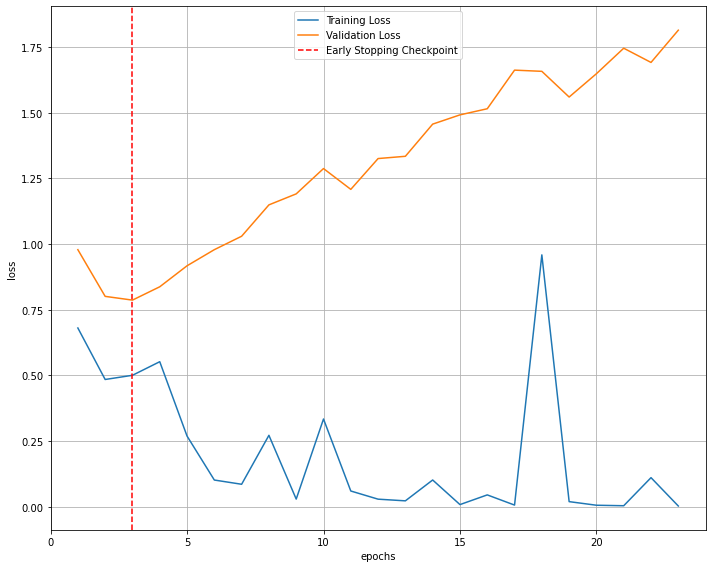

In [29]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

In [30]:
# 저장하기
state = {
        'epoch': num_epochs,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': valid_loss,
}
path ="/content/drive/MyDrive/capstone_design/more_datasets.pth"
torch.save(state,path)

In [31]:
# 불러오기
checkpoint = torch.load("/content/drive/MyDrive/capstone_design/more_datasets.pth")
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
model.train()

print(epoch)

100


In [32]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("가족관계")
            elif np.argmax(logits) == 1:
                test_eval.append("학업 및 진로")
            elif np.argmax(logits) == 2:
                test_eval.append("학교폭력/따돌림")
            elif np.argmax(logits) == 3:
                test_eval.append("대인관계(부부, 자녀)")
            elif np.argmax(logits) == 4:
                test_eval.append("대인관계")
            elif np.argmax(logits) == 5:
                test_eval.append("연애, 결혼, 출산")
            elif np.argmax(logits) == 6:
                test_eval.append("진로, 취업, 직장")
            elif np.argmax(logits) == 7:
                test_eval.append("재정, 은퇴, 노후준비")
            elif np.argmax(logits) == 8:
                test_eval.append("건강, 죽음")
            elif np.argmax(logits) == 9:
                test_eval.append("건강")
            elif np.argmax(logits) == 10:
                test_eval.append("직장, 업무 스트레스")
            elif np.argmax(logits) == 11:
                test_eval.append("재정")

            print(logits)
        print(">> 입력하신 내용에서 " + test_eval[0] + " 상황입니다.")

In [33]:
#질문 무한반복하기! 0 입력시 종료

end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '0' :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 주식 봤어? 많이 떨어졌던데. 코인도 장난아니게 떨어졌더라


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[-1.1053307  -0.6650753  -0.8925965  -0.7586454  -0.32443148 -1.554728
 -0.8520276   3.7991657  -0.35284528 -1.0484953  -0.8255097   4.8291883 ]
>> 입력하신 내용에서 재정 상황입니다.


하고싶은 말을 입력해주세요 : 필라테스 가야하는데 너무 귀찮아. 건강 챙기는건 너무 힘들어
[-1.444005   -1.2758718  -1.2926643  -1.3315225   1.1369772  -2.0127368
 -1.7725927  -1.2024355   4.5190835   4.1339235  -1.2090675   0.43590617]
>> 입력하신 내용에서 건강, 죽음 상황입니다.


하고싶은 말을 입력해주세요 : 내 취미가 일이 되니까 재미없어졌어. 퇴사하고싶음
[-2.1376712  -1.1412591  -1.6187044   0.18710893  1.489797   -1.634296
  2.3808668   1.3945271  -0.9527005  -1.1088961   2.9122875   0.7318313 ]
>> 입력하신 내용에서 직장, 업무 스트레스 상황입니다.


하고싶은 말을 입력해주세요 : 오늘 친구랑 싸웠어. 말다툼뿐이었지만 기분 상했어.
[-1.0547441  -0.58492774 -0.7488284   0.38920155  5.8346863  -1.3868945
 -0.9059111  -1.2863146   0.2548251  -0.40663382 -0.90045404 -0.34465808]
>> 입력하신 내용에서 대인관계 상황입니다.


하고싶은 말을 입력해주세요 : 학교에서 학교폭력을 당하고 있어. 그래서 너무 스트레스받아.
[-0.35743135  0.3025167   5.819428    1.0450755  -0.98612946 -0.9988151
 -1.6710459   0.15217528 -0.7882084  -

In [ ]:
#캐시 삭제
import gc
gc.collect()
torch.cuda.empty_cache()